## Classification.  Handling Imbalanced Data with downsampling

## Scenario
You are working as an analyst with this internet service provider. You are provided with this historical data about your company's customers and their churn trends. Your task is to build a machine learning model that will help the company identify customers that are more likely to default/churn and thus prevent losses from such customers.

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
pd.set_option('display.max_rows', 200)

In [2]:
churnData = pd.read_csv("DATA_Customer-Churn.csv")

In [3]:
churnData.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No,Yes,No,No,No,No,Month-to-month,29.85,29.85,No
1,Male,0,No,No,34,Yes,Yes,No,Yes,No,No,No,One year,56.95,1889.5,No
2,Male,0,No,No,2,Yes,Yes,Yes,No,No,No,No,Month-to-month,53.85,108.15,Yes
3,Male,0,No,No,45,No,Yes,No,Yes,Yes,No,No,One year,42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,No,No,No,No,No,Month-to-month,70.70,151.65,Yes


## Check the datatypes of all the columns in the data

In [4]:
churnData.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

### Converting TotalCharges column into numeric type

In [5]:
#churnData["TotalCharges"] = pd.to_numeric(churnData["TotalCharges"])
#We find some errors on that column (empty values, not NaN)

In [6]:
churnData.loc[488, 'TotalCharges']

' '

In [7]:
#If ‘coerce’, then invalid parsing will be set as NaN.
churnData["TotalCharges"] = pd.to_numeric(churnData["TotalCharges"], errors='coerce')

### Check for null values and replace them

In [8]:
churnData.isnull().values.any()

True

In [9]:
round(churnData.isna().sum()/len(churnData),4)*100

gender              0.00
SeniorCitizen       0.00
Partner             0.00
Dependents          0.00
tenure              0.00
PhoneService        0.00
OnlineSecurity      0.00
OnlineBackup        0.00
DeviceProtection    0.00
TechSupport         0.00
StreamingTV         0.00
StreamingMovies     0.00
Contract            0.00
MonthlyCharges      0.00
TotalCharges        0.16
Churn               0.00
dtype: float64

In [10]:
churnData=churnData.fillna(churnData.mean())

In [11]:
churnData["TotalCharges"].mean()

2283.3004408418697

In [12]:
churnData["TotalCharges"][churnData["TotalCharges"] > 0].mean()

2283.3004408418697

In [13]:
round(churnData.isna().sum()/len(churnData),4)*100

gender              0.0
SeniorCitizen       0.0
Partner             0.0
Dependents          0.0
tenure              0.0
PhoneService        0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
Contract            0.0
MonthlyCharges      0.0
TotalCharges        0.0
Churn               0.0
dtype: float64

In [14]:
churnData["Churn"] = churnData["Churn"].replace(('Yes','No'),(1,0))
churnData["Churn"]

0       0
1       0
2       1
3       0
4       1
       ..
7038    0
7039    0
7040    0
7041    1
7042    0
Name: Churn, Length: 7043, dtype: int64

## Check for imbalance data

In [15]:
churnData["Churn"].value_counts()

0    5174
1    1869
Name: Churn, dtype: int64

- Our target value is not good balanced

### Downsampling method to balance data
<b>In downsampling, we randomly sample without replacement from the majority class

In [16]:
category_0 = churnData[churnData["Churn"] == 0]
category_1 = churnData[churnData["Churn"] == 1]

In [17]:
len(category_0), len(category_1)

(5174, 1869)

<b> Take a random sample of majority class as long as minority class

In [19]:
category_0_down = category_0.sample(len(category_1))
print(category_0_down.shape)
print(category_1.shape)

(1869, 16)
(1869, 16)


In [20]:
data = pd.concat([category_0_down, category_1], axis=0)
#shuffling the data to not have a lot 0 at the beginning and a lot of 1 at the  
#it's important to shuffle now to split on train and test after
data = data.sample(frac=1)  #frac 1 means don't subset it, just shuffle it


In [21]:
data['Churn'].value_counts()

1    1869
0    1869
Name: Churn, dtype: int64

### Split the data into a training set and a test set just using 4 features

- tenure: Number of months the customer has stayed with the company (Multiple different numeric values)
- SeniorCitizen: Whether the client is a senior citizen or not ( 0, 1).
- MontlyCharges: The amount charged to the customer monthly (Multiple different numeric values).
- TotalCharges: The total amount charged to the customer (Multiple different numeric values).

In [22]:
X = data[['tenure', 'SeniorCitizen', 'MonthlyCharges','TotalCharges']]
y = data["Churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=11)

In [23]:
X_test

,tenure,SeniorCitizen,MonthlyCharges,TotalCharges
6247,60,0,89.55,5231.20
6142,42,0,50.25,2203.65
1549,1,0,45.85,45.85
1294,6,0,44.75,270.95
4539,67,0,79.70,5293.40
...,...,...,...,...
6389,58,0,19.55,1079.65
343,63,0,20.50,1328.15
5458,7,0,51.00,354.05
6820,59,0,93.35,5386.50


## 01. Logistic Regression model

In [24]:
log_model = LogisticRegression() 

### Scale the features 

In [25]:
#transform data
trans = StandardScaler()
trans.fit(X_train)
X_train_mod = trans.transform(X_train)
X_test_mod  = trans.transform(X_test)

- Change again X_train_mod and X_test mod to dataframe

In [26]:
X_train_mod = pd.DataFrame(X_train_mod, columns= X.columns)
X_test_mod = pd.DataFrame(X_test_mod, columns= X.columns)

In [27]:
X_train_mod.head()

,tenure,SeniorCitizen,MonthlyCharges,TotalCharges
0,-0.648203,-0.487425,1.358757,-0.354787
1,-0.773211,-0.487425,0.459644,-0.602717
2,-0.731541,-0.487425,1.074096,-0.444483
3,-1.064896,-0.487425,0.647104,-0.847713
4,-1.106566,-0.487425,-1.630186,-0.920194


In [28]:
#Fitting data
log_model.fit(X_train_mod, y_train)

LogisticRegression()

### Make Predictions

In [29]:
y_pred_train_log = log_model.predict(X_train_mod)
y_pred_test_log = log_model.predict(X_test_mod)

In [30]:
y_pred_train_log

array([1, 1, 1, ..., 0, 1, 0])

In [31]:
y_pred_test_log

array([0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0,

## Confusion Matrix

- We have to state that our positive label is Yes (and negative label is No), instead of 0, which is the default value

,Error_metric,Train,Test
0,Accuracy,0.736120,0.744652
1,Precision,0.736527,0.740541
2,Recall,0.738000,0.742547


Confusion matrix for the train set
[[1094  396]
 [ 393 1107]]


/home/dani/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


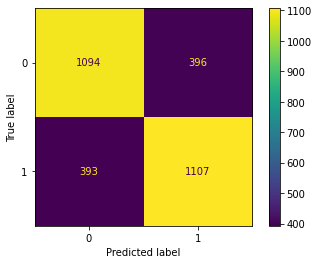



Confusion matrix for the test set
[[283  96]
 [ 95 274]]


/home/dani/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


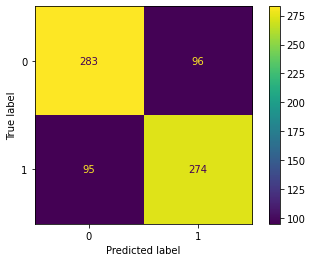

In [32]:
performance_log = pd.DataFrame({'Error_metric': ['Accuracy','Precision','Recall'],
                               'Train': [accuracy_score(y_train, y_pred_train_log),
                                         precision_score(y_train, y_pred_train_log,pos_label =1),
                                         recall_score(y_train, y_pred_train_log,pos_label = 1)],
                               'Test': [accuracy_score(y_test, y_pred_test_log),
                                        precision_score(y_test, y_pred_test_log,pos_label = 1),
                                        recall_score(y_test, y_pred_test_log,pos_label = 1
                                                    )]})

display(performance_log)

print("Confusion matrix for the train set")
print(confusion_matrix(y_train,y_pred_train_log))
plot_confusion_matrix(log_model,X_train_mod,y_train, values_format = 'd')
plt.show()

print()
print()

print("Confusion matrix for the test set")
print(confusion_matrix(y_test, y_pred_test_log))
plot_confusion_matrix(log_model,X_test_mod,y_test, values_format = 'd')
plt.show()

## 02. KNN CLASSIFIER


In [76]:
neigh = KNeighborsClassifier(n_neighbors=40)
neigh.fit(X_train_mod, y_train)  #X_train_mod is the scaled version

KNeighborsClassifier(n_neighbors=40)

### Make Predictions on KNN

In [77]:
y_pred_train_knn = neigh.predict(X_train_mod)
y_pred_test_knn = neigh.predict(X_test_mod)

In [78]:
y_pred_train_knn

array([1, 1, 1, ..., 0, 1, 0])

In [79]:
y_pred_test_knn

array([0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0,

### Confusion matrix on KNN with k=20

,Error_metric,Train,Test
0,Accuracy,0.758528,0.741979
1,Precision,0.749359,0.725641
2,Recall,0.779333,0.766938


Confusion matrix for the train set
[[1099  391]
 [ 331 1169]]


/home/dani/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


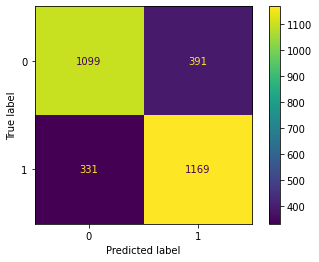



Confusion matrix for the test set
[[272 107]
 [ 86 283]]


/home/dani/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


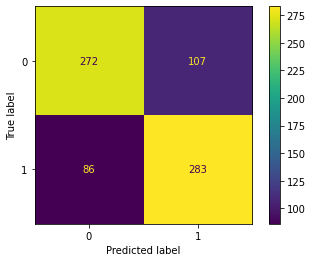

In [80]:
performance_KNN = pd.DataFrame({'Error_metric': ['Accuracy','Precision','Recall'],
                               'Train': [accuracy_score(y_train, y_pred_train_knn),
                                         precision_score(y_train, y_pred_train_knn,pos_label =1),
                                         recall_score(y_train, y_pred_train_knn,pos_label = 1)],
                               'Test': [accuracy_score(y_test, y_pred_test_knn),
                                        precision_score(y_test, y_pred_test_knn,pos_label = 1),
                                        recall_score(y_test, y_pred_test_knn,pos_label = 1
                                                    )]})

display(performance_KNN)

print("Confusion matrix for the train set")
print(confusion_matrix(y_train,y_pred_train_knn))
plot_confusion_matrix(neigh,X_train_mod,y_train, values_format = 'd')
plt.show()

print()
print()

print("Confusion matrix for the test set")
print(confusion_matrix(y_test, y_pred_test_knn))
plot_confusion_matrix(neigh,X_test_mod,y_test, values_format = 'd')
plt.show()

In [81]:
# make predictions
y_pred_train_knn = neigh.predict(X_train_mod)
y_pred_test_knn  = neigh.predict(X_test_mod)

#performance_knn, _, _ = model_performance(y_train, y_pred_train_knn, y_test, y_pred_test_knn)
#performance_knn

In [82]:
y_pred_train_knn

array([1, 1, 1, ..., 0, 1, 0])

- Let's make a for loop to try others value for k neighbours

In [83]:
full_knn = pd.DataFrame()

models = {'k': [] }

for k in range(2,80):

    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train_mod, y_train)

    models['k'] = [k, neigh]

    y_pred_train_knn = neigh.predict(X_train_mod)
    y_pred_test_knn  = neigh.predict(X_test_mod)
    temp_knn = pd.DataFrame({'k': [k]*3, 'Error_metric': ['Accuracy','Precision','Recall'],
                               'Train': [accuracy_score(y_train, y_pred_train_knn),
                                         precision_score(y_train, y_pred_train_knn,pos_label =1),
                                         recall_score(y_train, y_pred_train_knn,pos_label = 1)],
                               'Test': [accuracy_score(y_test, y_pred_test_knn),
                                        precision_score(y_test, y_pred_test_knn,pos_label = 1),
                                        recall_score(y_test, y_pred_test_knn,pos_label = 1
                                                    )]})
    full_knn = pd.concat([full_knn,temp_knn], axis=0)

full_knn

,k,Error_metric,Train,Test
0,2,Accuracy,0.841137,0.697861
1,2,Precision,0.997090,0.767790
2,2,Recall,0.685333,0.555556
0,3,Accuracy,0.837458,0.691176
1,3,Precision,0.833553,0.679688
...,...,...,...,...
1,78,Precision,0.737931,0.724747
2,78,Recall,0.784667,0.777778
0,79,Accuracy,0.751839,0.740642
1,79,Precision,0.734820,0.717122


In [84]:
### Best accuracy
full_knn[full_knn['Error_metric'] == 'Accuracy']

,k,Error_metric,Train,Test
0,2,Accuracy,0.841137,0.697861
0,3,Accuracy,0.837458,0.691176
0,4,Accuracy,0.812375,0.711230
0,5,Accuracy,0.806355,0.727273
0,6,Accuracy,0.790635,0.720588
0,7,Accuracy,0.790301,0.720588
0,8,Accuracy,0.787625,0.719251
0,9,Accuracy,0.789298,0.721925
0,10,Accuracy,0.788294,0.727273
0,11,Accuracy,0.784281,0.728610


In [85]:
full_knn_2 = full_knn.melt(id_vars=['k','Error_metric'])
full_knn_2

,k,Error_metric,variable,value
0,2,Accuracy,Train,0.841137
1,2,Precision,Train,0.997090
2,2,Recall,Train,0.685333
3,3,Accuracy,Train,0.837458
4,3,Precision,Train,0.833553
...,...,...,...,...
463,78,Precision,Test,0.724747
464,78,Recall,Test,0.777778
465,79,Accuracy,Test,0.740642
466,79,Precision,Test,0.717122


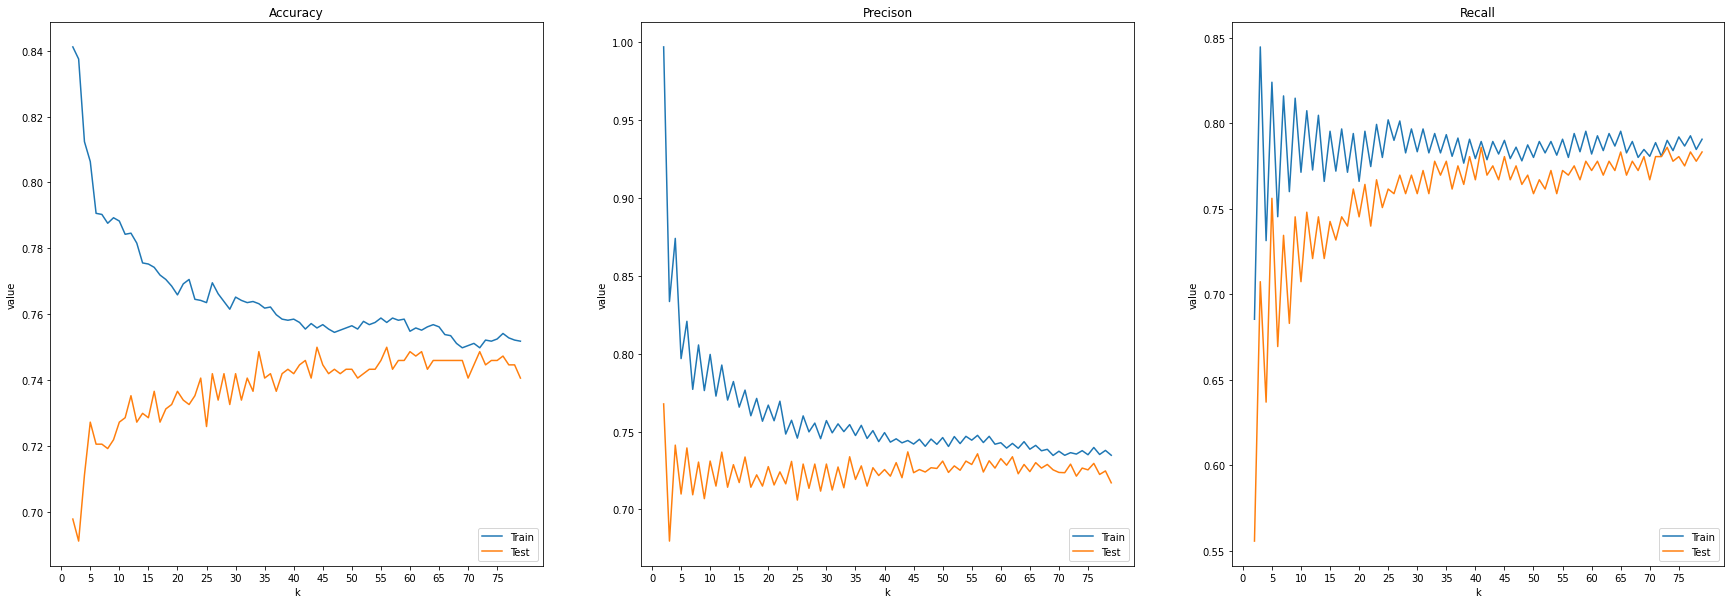

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

#metrics = ['Mean error',]'Mean absolute error',...]

fig, ax = plt.subplots(1,3, figsize=(30,10))
sns.lineplot(x = 'k', y = 'value', data = full_knn_2[full_knn_2['Error_metric'] == 'Accuracy'], hue = 'variable', ax = ax[0])
ax[0].set_xticks((np.arange(0, 80, 5)))
ax[0].set_title("Accuracy")
ax[0].legend(loc='lower right')

sns.lineplot(x = 'k', y = 'value', data = full_knn_2[full_knn_2['Error_metric'] == 'Precision'], hue = 'variable', ax = ax[1])
ax[1].set_xticks((np.arange(0, 80, 5)))
ax[1].set_title("Precison")
ax[1].legend(loc='lower right')

sns.lineplot(x = 'k', y = 'value', data = full_knn_2[full_knn_2['Error_metric'] == 'Recall'], hue = 'variable', ax = ax[2])
ax[2].set_xticks((np.arange(0, 80, 5)))
ax[2].set_title("Recall")
ax[2].legend(loc='lower right')

In [87]:
full_knn_2[full_knn_2['k'] == 40]

,k,Error_metric,variable,value
114,40,Accuracy,Train,0.758528
115,40,Precision,Train,0.749359
116,40,Recall,Train,0.779333
348,40,Accuracy,Test,0.741979
349,40,Precision,Test,0.725641
350,40,Recall,Test,0.766938


In [111]:
full_knn_2[full_knn_2['k'] == 41]

,k,Error_metric,variable,value
117,41,Accuracy,Train,0.757525
118,41,Precision,Train,0.743252
119,41,Recall,Train,0.789333
351,41,Accuracy,Test,0.744652
352,41,Precision,Test,0.721393
353,41,Recall,Test,0.785908


In [109]:
full_knn_2[full_knn_2['k'] == 56]

,k,Error_metric,variable,value
162,56,Accuracy,Train,0.757525
163,56,Precision,Train,0.747604
164,56,Recall,Train,0.780000
396,56,Accuracy,Test,0.750000
397,56,Precision,Test,0.735751
398,56,Recall,Test,0.769648


For the moment I'll say 40 k

## 03. DECISION TREE

In [90]:
tree = DecisionTreeClassifier(max_depth=3)

- We don't need to use scaled data

In [91]:
tree.fit(X_train, y_train)

y_pred_train_dt = tree.predict(X_train)
y_pred_test_dt = tree.predict(X_test)


performance_dt = pd.DataFrame({'Error_metric': ['Accuracy','Precision','Recall'],
                               'Train': [accuracy_score(y_train, y_pred_train_dt),
                                         precision_score(y_train, y_pred_train_dt),
                                         recall_score(y_train, y_pred_train_dt)],
                               'Test': [accuracy_score(y_test, y_pred_test_dt),
                                        precision_score(y_test, y_pred_test_dt),
                                        recall_score(y_test, y_pred_test_dt)]})

In [92]:
display(performance_dt)

,Error_metric,Train,Test
0,Accuracy,0.739465,0.716578
1,Precision,0.702870,0.677201
2,Recall,0.832667,0.813008


/home/dani/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/home/dani/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


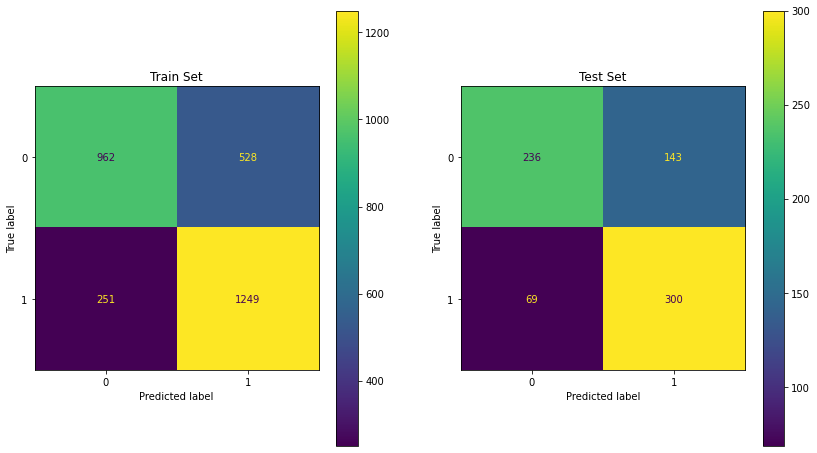

In [93]:
fig, ax = plt.subplots(1,2, figsize=(14,8))


#print("Confusion matrix for the train set")
#print(confusion_matrix(y_train,y_pred_train_dt).T)
plot_confusion_matrix(tree,X_train,y_train,ax=ax[0], values_format = 'd')
ax[0].title.set_text("Train Set")

#print("Confusion matrix for the test set")

#print(confusion_matrix(y_test,y_pred_test_dt).T)
plot_confusion_matrix(tree,X_test,y_test,ax=ax[1],values_format = 'd')
ax[1].title.set_text("Test Set")

<BarContainer object of 4 artists>

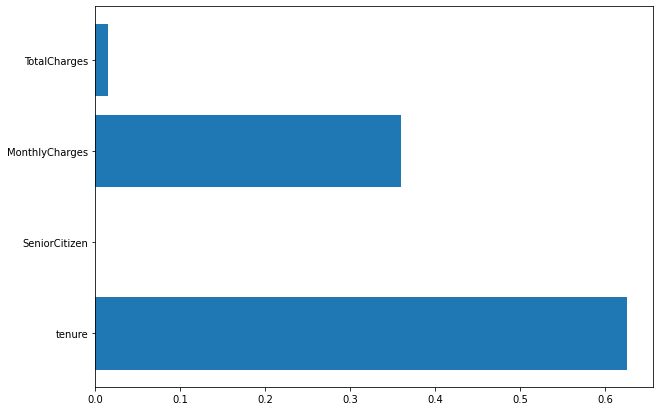

In [94]:
plt.figure(figsize=(10,7))
plt.barh(X.columns,tree.feature_importances_)

In [95]:
X["tenure"].unique()

array([62,  1, 28, 47, 10, 24, 67, 25, 41, 39, 46, 20, 61, 12, 71, 27, 45,
       11, 42, 65,  6, 22, 66, 53, 72,  3,  9,  7, 51, 13, 15, 64,  4,  2,
       14, 26, 48, 63, 29,  5, 38, 32, 44, 56, 34, 19, 35, 16, 37, 59, 52,
        8, 50, 68, 17, 49, 60, 69, 31, 70, 55, 43, 33, 30, 54, 23, 36,  0,
       21, 18, 40, 58, 57])

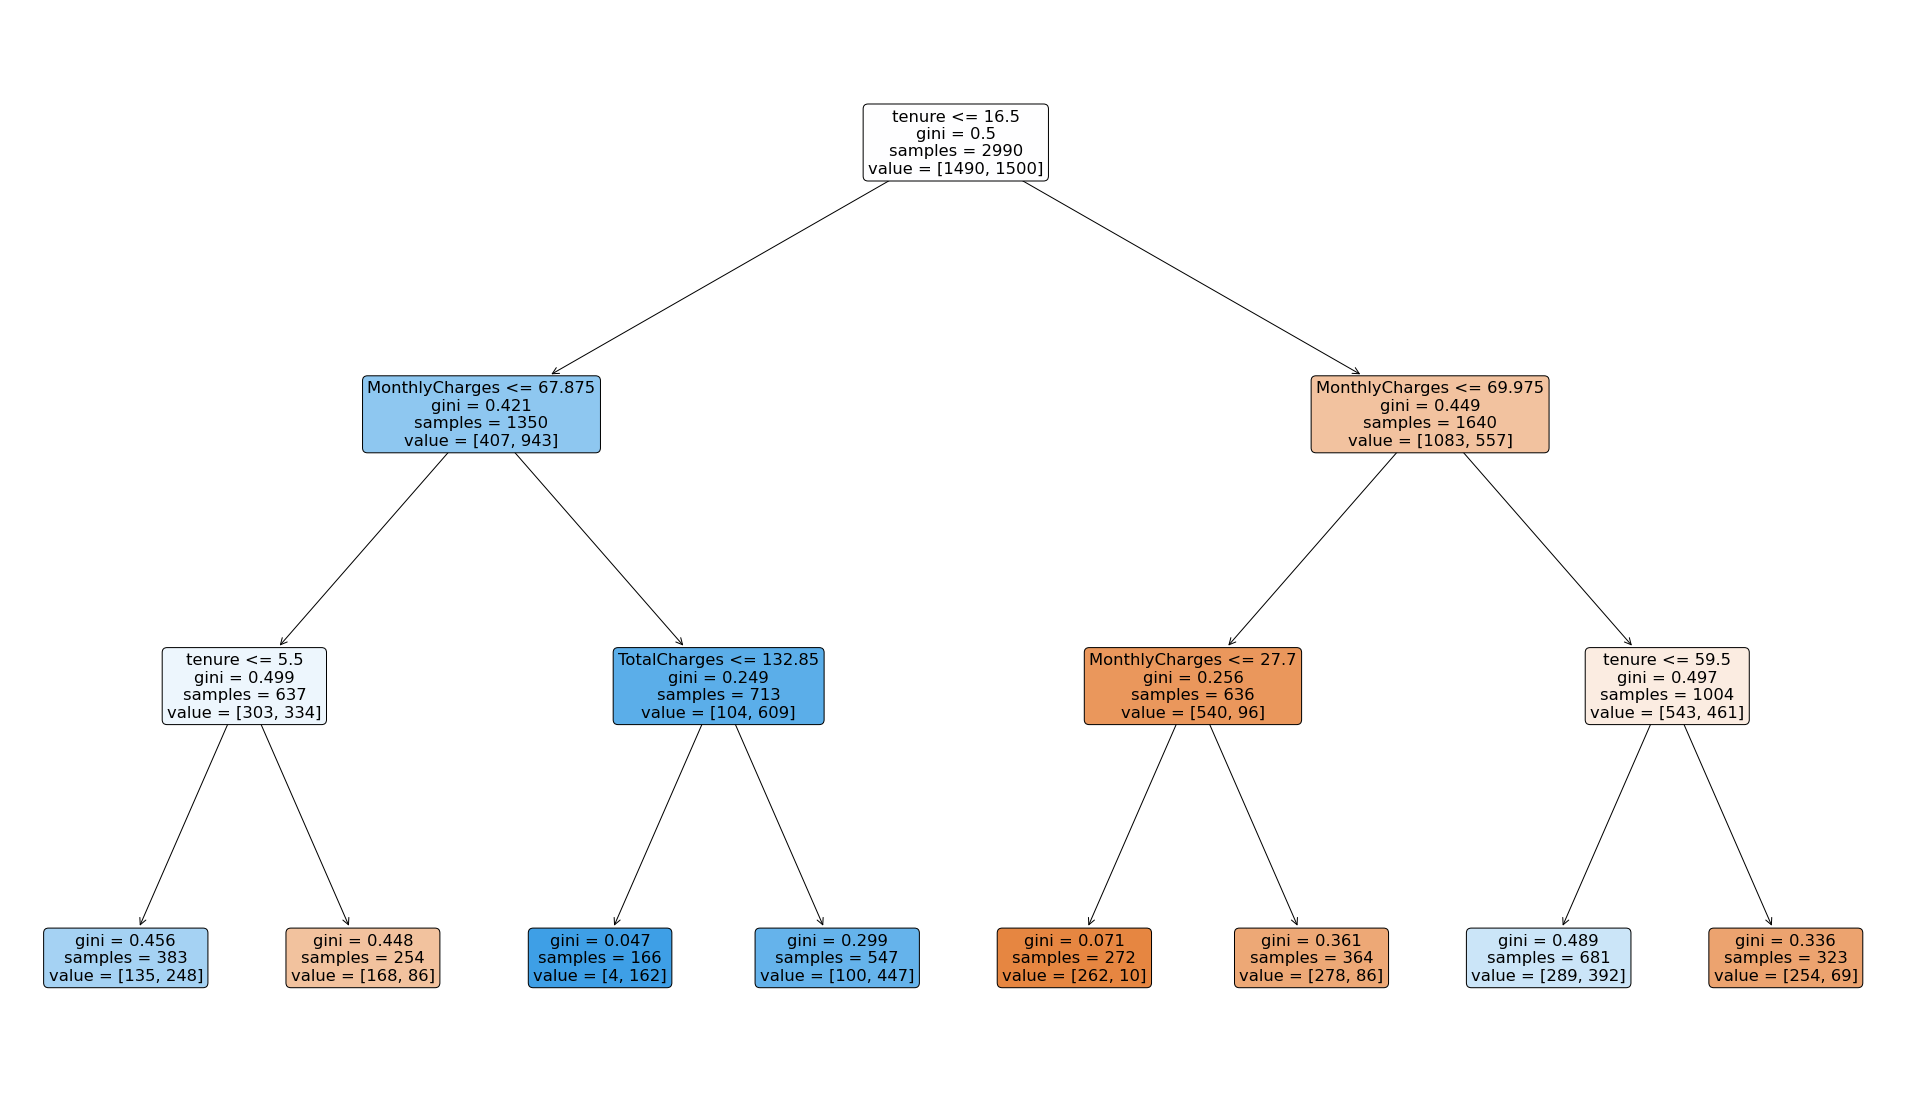

In [96]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (34,20))

plot_tree(tree,filled = True, rounded=True,feature_names=X.columns)
plt.show() 

In [97]:
len(X_train)

2990

In [98]:
X_train["tenure"].mean()

27.555852842809365

In [99]:
X_train.describe()

,tenure,SeniorCitizen,MonthlyCharges,TotalCharges
count,2990.000000,2990.000000,2990.000000,2990.000000
mean,27.555853,0.191973,67.559415,2027.781756
std,24.002455,0.393918,28.810994,2181.623513
min,0.000000,0.000000,18.400000,18.850000
25%,5.000000,0.000000,45.412500,280.850000
50%,21.000000,0.000000,74.350000,1133.200000
75%,48.000000,0.000000,90.550000,3229.587500
max,72.000000,1.000000,118.650000,8684.800000


We see that senior citizen doesn't affect (feature importance is 0), let's try not include it on the decision tree

In [100]:
performance_log

,Error_metric,Train,Test
0,Accuracy,0.736120,0.744652
1,Precision,0.736527,0.740541
2,Recall,0.738000,0.742547


In [101]:
performance_KNN

,Error_metric,Train,Test
0,Accuracy,0.758528,0.741979
1,Precision,0.749359,0.725641
2,Recall,0.779333,0.766938


In [102]:
performance_dt

,Error_metric,Train,Test
0,Accuracy,0.739465,0.716578
1,Precision,0.702870,0.677201
2,Recall,0.832667,0.813008


### K-fold cross validation on your models 

<b>Log model

In [103]:
#log_model
log_scores=cross_val_score(log_model, X_train_mod, y_train, cv=10)
log_scores

array([0.69565217, 0.73578595, 0.7826087 , 0.70234114, 0.77257525,
       0.71571906, 0.74916388, 0.73578595, 0.75585284, 0.71237458])

In [104]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (log_scores.mean(), log_scores.std()))

0.74 accuracy with a standard deviation of 0.03


<b>Knn classifier

In [105]:
#neigh
neigh_scores=cross_val_score(neigh, X_train_mod, y_train, cv=10)
neigh_scores

array([0.67892977, 0.74916388, 0.76923077, 0.75250836, 0.76254181,
       0.7458194 , 0.77926421, 0.73244147, 0.77926421, 0.76923077])

In [106]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (neigh_scores.mean(), neigh_scores.std()))

0.75 accuracy with a standard deviation of 0.03


<b>Decision tree

In [107]:
#tree
tree_scores=cross_val_score(tree, X_train, y_train, cv=10)
tree_scores

array([0.65551839, 0.71906355, 0.7458194 , 0.73244147, 0.75919732,
       0.71906355, 0.74247492, 0.73913043, 0.76588629, 0.7458194 ])

In [108]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (tree_scores.mean(), tree_scores.std()))

0.73 accuracy with a standard deviation of 0.03
